# Multi-Scale Entropy Computation Tutorial

written by Liliana Polyanska & Niels Kloosterman (Lifespan Neural Dynamics Group)

### Introduction

The msecomputation script was developed for calculating multi-scale entropy from EEG/MEG time series data. Data can be coarse-grained for higher scales using one of the two coarse-graining functions provided. In addition, memory usage is kept in check and the function is optimized for running on a gpu. Thanks to using a 3D matrix, data from all channels can be efficiently processed at the same time. The script computes mse for each of the specified time windows, thus allowing to look at entropy changes over time.

For the purpose of this tutorial, parameters were kept simple, so that to best exemplify the mechanics of the mse computations. Thus, data consists of 1 channel x 20 time points. The function is run only for scale 2. <br>
Some variables are visualized to help understand how the function works. When you run it, no plots will automatically appear. <br><br>

This is what original time series data looks like.

In [10]:
from IPython.display import Image
from IPython.display import display

In [30]:
original_data = Image(filename = "img/original_data.png")
cg_data = Image(filename = "img/cg_data.jpg")
ymat_1_2 = Image(filename = "img/ymat_1_2.jpg")
ymat_k1_k3 = Image(filename = "img/ymat_k1_k3.jpg")

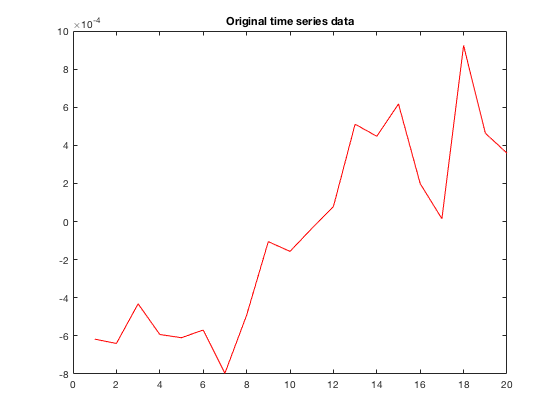

In [12]:
display(original_data)

*** 

You determine the number and length of the time windows for which mse will be computed. The script then iterates over these windows in the **itoi** loop. <br>
Quality check is done to verify that there is a sufficient number of trials in the current time window.

In [ ]:
for itoi = 1:ntoi
    % select time window of interest from each trial
    tmpcfg=[];
    tmpcfg.toilim = [toi(itoi)-timwin*0.5 toi(itoi)+timwin*0.5];
    data_sel = ft_redefinetrial(tmpcfg, data);
    
    % only take trials that have the whole interval
    tmpcfg = [];
    tmpcfg.minlength = timwin; 
    data_sel = ft_redefinetrial(tmpcfg, data_sel);
    
    % need 40 samples for mse calc, 3 smp per trial for scale 42: 40/3 = 13.3 trials, make 15
    ntrials = length(data_sel.trialinfo);
    if ntrials < 1
        warning('Time point %g: Not enough trials remain', toi(itoi))
        break % subsequent time points will also not work
    end

For each channel, **r_new** determines the portion of SD that corresponds to **r** (similarity criterion). 
The script will later look for points that comprise a pattern only within this range. <br>
**r_new** is a *n channels* x *1* vector. 

In [ ]:
    % calculate similarity criterion
    r_new = r * std(cell2mat(data_sel.trial),1,2);
    nchan = size(data_sel.trial{1},1);

#### Loop over scales
mse is calculated for each scale separately.

In [ ]:
    for s = 1:numel(timescales) %  loop through timescales
        sc = timescales(s);
        fprintf('Scale %d - %d\n', sc, length(timescales))

#### Coarse-grain time series at the current scale
You can choose from two coarse-graining methods: **filtskip** and **pointavg**. <br><br>
**filtskip** resamples the signal by grouping the original data points into multiple starting points, whose number depends on the current scale. E.g. scale 2 has 2 starting points, scale 3 has 3, etc. You can imagine coarse-graining with this method as dividing the number of time points in the original time series by the current scale and then allocating them to the corresponding starting points. For example, to coarse-grain at the scale 3, every first time point of the original time series would be allocated to starting point 1, every second to starting point 2, and every third to starting point 3. In addition, this coarse-graining method adds mean padding to avoid filter artifacts. <br><br>
With **pointavg** data is coarse-grained by taking the average of the adjacent time points according to the current scale. For instance, to coarse-grain at scale 3, this method will first average points 1 to 3, then points 2 to 4, then points 3 to 5, etc. <br><br>
Regardless of the method you choose, at scale 1 (native sampling rate) no coarse-graining is done. <br><br>
Note that the number of loops over starting points depends on the coarse-graining function. If using **filtskip**, the function will loop over starting points, which correspond to the current scale. If using **pointavg**, there is only one starting point for each scale. <br><br>
Coarse-grained data is stored in a variable **cg_data**, which is a cell array of size *n starting points* x *1*, containing in each cell: *1* x *n trials* cell array, which again in each cell contains a matrix of size *n channels* x *n sample points* (for current coarse-graining level).

In [ ]:
        cg_data = {};
        if sc == 1 % no caorse graining for native sampling rate
            cg_data{1} = data_sel.trial; %only keep trial data
            nloops = 1; % no loop across starting points
        else % coarse-grain time series at this time scale
            switch coarsegrainmethod
                case 'filtskip'
                    L = sc-1; % from Semmlow book
                    cutoff = 1/(1+L);   % Butter defines the cutoff % frequency in terms of fs/2
                    filtord = 6;
                    [B,A] = butter(filtord,cutoff); % Define filter
                    
                    padlength = 512;
                    x_pad = cellfun(@(a) ft_preproc_padding(a, 'mean', padlength), data_sel.trial, 'UniformOutput', false );  % add padding
                    x_pad = cellfun(@transpose, x_pad, 'UniformOutput', false); % transpose for filtfilt: time x chan
                    resamp_x_pad = cellfun(@(x_pad) filtfilt(B,A,x_pad), x_pad, 'UniformOutput', false );  % add padding% Filter
                    resamp_x_pad = cellfun(@transpose, resamp_x_pad, 'UniformOutput', false); % transpose back : chan x time again
                    resamp_x = cellfun(@(resamp_x_pad) ft_preproc_padding(resamp_x_pad, 'remove', padlength), resamp_x_pad, 'UniformOutput', false );  % add padding% Filter
                    % close all; figure; plot(x_pad); hold on; plot(resamp_x)
                    
                    nloops = sc;
                    cg_data = cell(nloops,1); % make cell: cg_data{istart}{trials}(chan-by-time)
                    for is = 1:nloops % loop over starting points here!
                        cg_data{is} = cellfun(@(resamp_x) resamp_x(:, is:(L+1):end), resamp_x, 'UniformOutput', false );  % add padding% Filter
                    end
                    
                case 'pointavg' % original point averaging coarse graining, no loop over starting points
                    nloops = 1; % no loop across starting points
                    nchan = size(data_sel.trial{1},1);
                    for itrial = 1:length(data_sel.trial)
                        num_cg_tpts = floor(length(data_sel.trial{itrial})/sc); % number of coarse-grained time points
                        cg_data{1}{itrial} = zeros(nchan, num_cg_tpts); % preallocate cg_data matrix
                        for t = 1:num_cg_tpts % calculate coarse_grained time series
                            cg_data{1}{itrial}(:,t) = mean( data_sel.trial{itrial}(:, (t-1)*sc + [1:sc]) ,2);
                        end
                    end
            end
        end

This is what data now looks like, after it's been coarse-grained with the **filtskip** method.

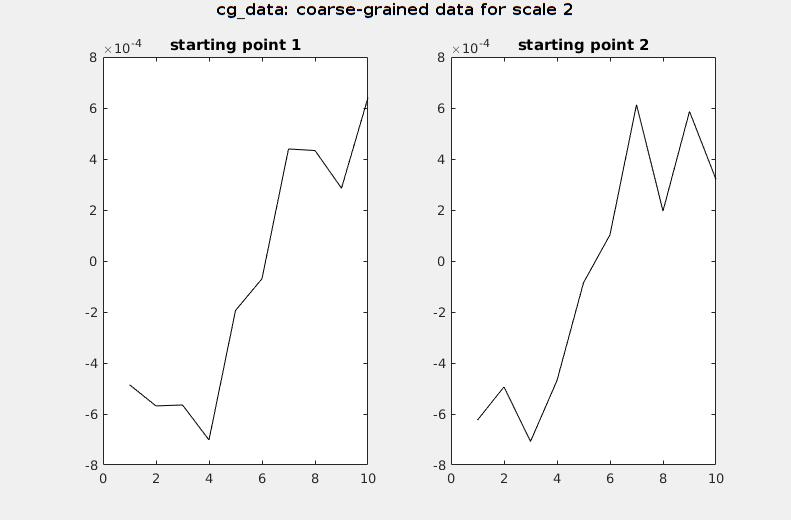

In [16]:
display(cg_data)

#### Loop mse computation over starting points
Here, the data is converted to a format that speeds up the computations: coarse-grained time series of the current starting point from all trials are concatenated into one matrix (**y**). In addition, converting this matrix to type single ensures that it takes up as little memory as possible, to avoid problems with further computations. <br><br>
Now that the data matrix is aggregated over trials, time points that were separated in time become adjacent. To avoid counting patterns over the trial borders, a logical mask is created and the two last time points of each trial are masked with 0s. <br><br>
Also, checks are implemented to make sure that the coarse-grained time series is long enough to make mse computation meaningful. <br><br>
The rationale for this portion of the code can be found in *Grandy, T. H., Garrett, D. D., Schmiedek, F., & Werkle-Bergner, M. (2016). On the estimation of brain signal entropy from sparse neuroimaging data. Scientific Reports, http://doi.org/10.1038/srep23073*

In [ ]:
        % after coarsegraining, loop mse computation across starting points
        allcont = zeros(sc, nchan, m+1); % start_chan_m
        for istart = 1:nloops
            
            if max(cellfun(@(x) size(x,2), cg_data{istart})) == m % TODO check this at start
                fprintf('Coarse grained trials below %d + 1 samples, skipping remaining starting points\n', m)
                break
            end
            
            %  concatenate trials and convert to single
            y = single(cell2mat(cg_data{istart}));
            
            % collect trial bounds and create mask with valid time points for pats
            trl_bounds = cumsum(cellfun(@(x) size(x,2), cg_data{istart}))';
            trl_mask = true(size(y,2),1);
            if allowgpu && gpuavailable 
                trl_mask = gpuArray(trl_mask);
            end
            trl_mask([trl_bounds-1; trl_bounds]) = false;
            
            %  return if n possible matches < 40 (Grandy)
            npossiblepats = length(find(trl_mask)); % TODO check this at start
            if npossiblepats < 40
                fprintf('N data points < 40, returning\n')
                return
            end

If **normalized_r** was set to 1 (default), the similarity criterion (**r_new**) will be recomputed for each starting point. <br><br>
*Chunking* is applied to avoid memory problems when **ymat** is squared later on. Data for each starting point (**y**) is divided into chunks based on the maximum amount of memory assigned in the settings (in the variable called **mem_available**) and the number of time points in **y**. Note that more efficient memory usage is ensured by storing the elements of the time series as single. <br>
Chunks are programmed to overlap, as they would otherwise create artificial borders in the data.

In [ ]:
            %  Calculate sample entropy of coarse grained time series
            if normalized_r % calculate similarity criterion FOR EACH SCALE and sp SEPARATELY.
                r_new = r * std(y,1,2);
            end
            
            % chunk y to keep memory usage in check
            max_numel = mem_available/4; % single = 4 bytes
            chunk_size = round(max_numel/numel(y));
            n_chunks = ceil(size(y,2)/chunk_size);
            temp = 1;
            chunk_borders = zeros(n_chunks,2);
            for ic = 1:n_chunks
                chunk_borders(ic,:) = [temp temp+chunk_size];
                temp = temp+chunk_size-1; % chunks need to overlap to avoid missing pats at chunk borders
            end
            chunk_borders(end) = size(y,2);
            clear temp

Using 3D matrices allows to simultaneously determine patterns over all time points of a current chunk, all pattern points, and all channels, which speeds up computations. <br>
**ymat** determines the patterns by squaring the time point vector for each channel and taking the difference of all points, while also accounting for the similarity criterion. As the patterns are squared, the matrix is divided diagonally and only one half of it is taken as an end result. <br> **ymat** is a logical gpu array with dimensions *n elements in the current chunk* x *all sample points of the current starting point* x *n channels*.

In [ ]:
            fprintf('starting point %d\n', istart)
            cont = zeros(m+1, n_chunks, nchan);
            y_chunk1 = shiftdim(y', -1 ); % insert singleton dim
            r_new2 = shiftdim(r_new, -2);
            if allowgpu && gpuavailable 
                cont = gpuArray(cont);
                y_chunk1 = gpuArray(y_chunk1);
                r_new2 = gpuArray(r_new2);
            end
            
            fprintf('%d chunks: ', n_chunks)
            for ic = 1:n_chunks
                fprintf('%d ', ic)
                
                y_inds = transpose(chunk_borders(ic,1):chunk_borders(ic,2));
                
                y_chunk2 = permute(y_chunk1(1,y_inds,:), [2 1 3]); % insert singleton dim
                if allowgpu && gpuavailable 
                    y_chunk2 = gpuArray(y_chunk2);
                end
                
                ymat = bsxfun(@le, abs(bsxfun(@minus, y_chunk1, y_chunk2 )), r_new2 );
                for ichan=1:nchan % loop since triu only supports 2D
                    ymat(:,:,ichan) = triu(ymat(:,:,ichan), chunk_borders(ic,1));
                end

For starting point 1 of scale 2, **ymat** computations can be visualized as follows. Here, violet color stands for 0, yellow stands for 1.

In [9]:
from IPython.display import Image
Image(filename = "img/ymat1.jpg") | Image(filename = "img/ymat2.jpg")

TypeError: unsupported operand type(s) for |: 'Image' and 'Image'

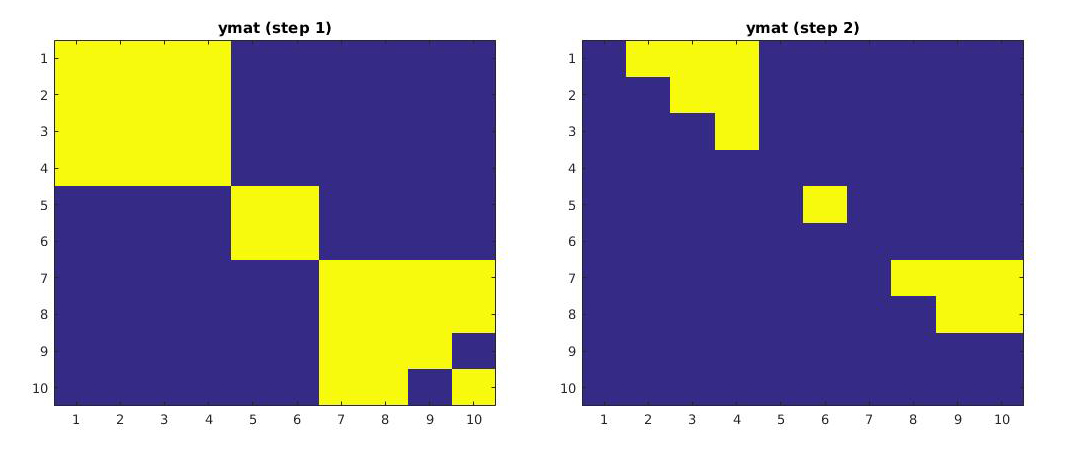

In [31]:
display(ymat_1_2)

The number of patterns is counted by shifting **ymat** to the left. Assuming that you're interested in 2- and 3-point patterns (i.e. **m**=2, as per default), first the number of 2-point patterns is counted, then the matrix is shifted and the number of 3-point patterns is counted.

In [ ]:
                for k = 1:m+1
                    if k >= m % TODO try for m > 2
                        cont(k,ic,:) = sum(reshape(ymat(trl_mask(y_inds(1:end-2)), trl_mask, :), [], nchan));
                    end
                    if k < m+1
                        ymat = ymat & circshift(ymat, [-1 -1 0]);
                    end
                end
                clear ymat y_inds y_chunk2
            end

Below you see ymat at each point of pattern counting: 1-point (k=1), 2-point (k=2), and 3-point (k=3) patterns. Note, only 2- and 3-point patterns are recorded in the results.

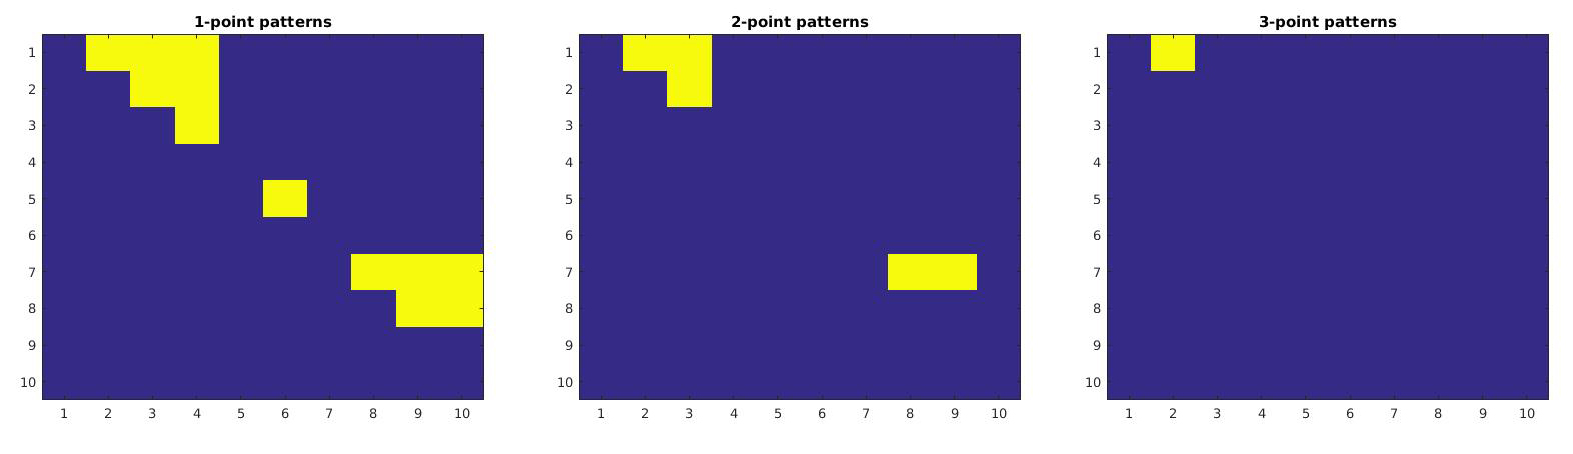

In [33]:
display(ymat_k1_k3)

Get the results.

In [ ]:
            allcont(istart, :, :) = gather(squeeze(sum(cont,2))'); % sum over chunks. dimord: start_chan_m
            fprintf('\n')
        end % cg starting points
        
        allcont = sum(allcont,1); % sum counts over starting points

Calculate sample entropy using its formula.

In [ ]:
        %  calculate sample entropy
        for ichan=1:nchan
            if allcont(1,ichan,m+1) == 0 || allcont(1,ichan,m) == 0
                fprintf('zero patterns found!\n')
                %         nlin_sc = size(pnts,1); % ori THG code
                %         mse(s) = -log(1/((nlin_sc)*(nlin_sc -1)));
                sampen(ichan,sc,itoi) = -log(1/(npossiblepats*(npossiblepats-1)));
            else
                sampen(ichan,sc,itoi) = -log(allcont(1,ichan,m+1)./allcont(1,ichan,m)); % same as log(cont(m)/cont(m+1))
            end
        end
        
    end % for timescales
end % for toi